## Drug-disease link classification using knowledge graph

This notebook contains scripts to train and evaluate a classifier that predicts whether a drug treats a disease.

The problem is formulated as a graph edge class prediction. The provided node embeddings are used as starting node features, and applied graph convolutional network to incorporate the graph structure during classification.

Below, I describe feature engineering, model training, and evaluation workflows.

## Load required libraries

In [1]:
# Import autoreload extension
%load_ext autoreload
# Enable autoreload for all modules
%autoreload 2

import os, re
import pandas as pd 
import torch
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from tqdm import tqdm
from sklearn.metrics import ConfusionMatrixDisplay

from data_handling import (get_embd_as_list_float, plot_nodes_degree_distribution, get_graph_data, 
stratified_train_test_split, get_train_val_test_graph, create_graph_data)

from train import EdgeClassifier, train_model

from eval import run_inference, compute_metrics


## Define variables

In [2]:
data_dir = "data/" # this is where graph data is strored: "Embeddings.csv" and "Ground Truth.csv"
output_dir = "output/"
os.makedirs(output_dir, exist_ok=True)
# Number of output classes for the 

# Flag to indicate if the graph is directed (True) or undirected (False)
# YOU CAN CHANGE THIS VARIABLE TO SEE CHANGE IN PERORMANCE
directed_graph = False

# Dimensionality of the feature vectors for the graph nodes
featured_dim = 128
num_classes = 2

# Number of training epochs
epochs = 1000

# Number of epochs with no improvement to trigger early stopping
early_stop = 40

# Dropout rate for regularization during training
drop_rate = 0.3

# Device to use for computations: GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Directory to save outputs, including the directed graph information in its name
save_dir = os.path.join(output_dir, f"directed_G_{directed_graph}")

# Create the output directory if it does not already exist
os.makedirs(save_dir, exist_ok=True)

## Load embedding and ground truth data

In [3]:
embd_csv = pd.read_csv(os.path.join(data_dir, "Embeddings.csv"), usecols=['id', 'topological_embedding'])
print(f"The embedding file contain {len(embd_csv)} entries")

The embedding file contain 170009 entries


In [4]:
# View first 5 elements
embd_csv.head(5)

,id,topological_embedding
0,UniProtKB:P53805,[-0.09720507 -0.02366368 -0.01756126 -0.096430...
1,UniProtKB:Q4KWH8,[ 0.05282909 0.16689758 0.17749593 0.028352...
2,UniProtKB:Q9UPU7,[-1.98048055e-02 3.08241490e-02 -1.16399840e-...
3,UniProtKB:P35462,[-0.16700847 0.00287975 -0.02125628 -0.196755...
4,UniProtKB:Q9UJY1,[-2.49186769e-01 -2.17781356e-03 -1.74910173e-...


In [5]:
## Read ground truth data 
gt = pd.read_csv(os.path.join(data_dir, "Ground Truth.csv"))
print(f"The ground truth file contain {len(gt)} connections")

The ground truth file contain 28368 connections


In [6]:
# View first 5 rows
gt.head(5)

,Unnamed: 0,source,target,y
0,0,CHEMBL.COMPOUND:CHEMBL30,MONDO:0007186,1
1,1,CHEMBL.COMPOUND:CHEMBL3707202,MONDO:0007186,1
2,2,CHEMBL.COMPOUND:CHEMBL1502,MONDO:0007186,1
3,3,CHEMBL.COMPOUND:CHEMBL480,MONDO:0007186,1
4,4,CHEMBL.COMPOUND:CHEMBL3833310,MONDO:0007186,1


## Visualise class distribution

Text(0.5, 1.0, 'Class distribution')

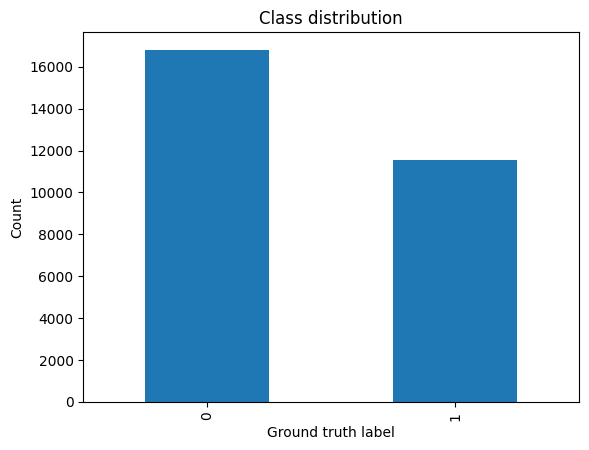

In [7]:
ax = gt.y.value_counts().plot(kind='bar')
ax.set_ylabel("Count")
ax.set_xlabel("Ground truth label")
ax.set_title("Class distribution")

## Check if all nodes in the ground truth are in embedding file

In [8]:
if len(set(embd_csv.id).intersection(gt.source)) == len(set(gt.source)):
    print(f"Pass: All SOURCE nodes in ground truth are in embedding file")
else:
    raise Exception("Fail: Some SOURCE nodes in ground truth file are not in embedding file")

Pass: All SOURCE nodes in ground truth are in embedding file


In [9]:
if len(set(embd_csv.id).intersection(gt.target)) == len(set(gt.target)):
    print(f"Pass: All TARGET nodes in ground truth are in embedding file")
else: 
    raise Exception("Fail: Some TARGET nodes in ground truth file are not in embedding file")

Pass: All TARGET nodes in ground truth are in embedding file


## Extract embedding of nodes with ground truth 

In [10]:
# Combine unique node IDs from the 'target' and 'source' columns of the `gt` dataframe into a single list
nodes = list(gt.target.unique()) + list(gt.source.unique())

# Filter the `embd_csv` dataframe to keep only rows where the 'id' column matches one of the nodes in the `nodes` list
embd_csv = embd_csv.loc[embd_csv['id'].isin(nodes), :].reset_index(drop=True)

print(f"After filtering there are {len(embd_csv)} entries")

# Convert the 'topological_embedding' column from its current format (string)
# into a list of floats using the `get_embd_as_list_float` function
embd_csv["topological_embedding"] = embd_csv["topological_embedding"].map(get_embd_as_list_float)


After filtering there are 3785 entries


## Visualise nodes degree

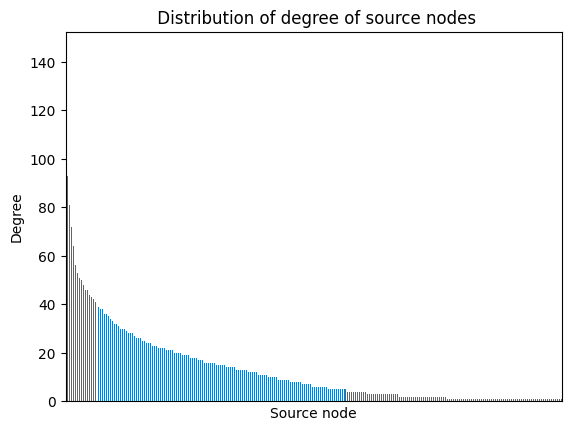

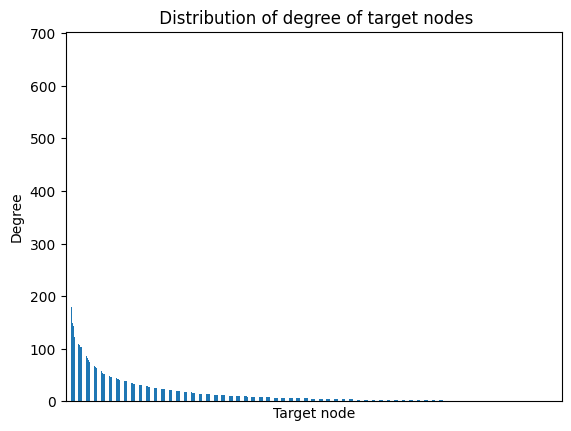

In [11]:
plot_nodes_degree_distribution(gt)

## Create geometric dataset from knowledge graph

In [12]:
# Split the graph `gt` into training, validation, and test subgraphs
train, val, test = get_train_val_test_graph(gt)

# Prepare the graph data for each split (train, validation, and test)
train_graph_data, val_graph_data, test_graph_data = get_graph_data(
    embd_csv,    # The dataframe containing embeddings for nodes
    train,       # Training subgraph
    val,         # Validation subgraph
    test,        # Test subgraph
    directed_graph=directed_graph  # Whether the graph is directed or not 
)


Training set size: 17369
Test set size: 5752
Validation set size: 5247
Create TRAINING graph data...
Node features/embedding dimension:torch.Size([3011, 128])
Edge index dimension:torch.Size([2, 34738])
Edge labels dimension:torch.Size([34738])
Create VALIDATION graph data..
Node features/embedding dimension:torch.Size([1668, 128])
Edge index dimension:torch.Size([2, 10494])
Edge labels dimension:torch.Size([10494])
Create TEST graph data...
Node features/embedding dimension:torch.Size([1805, 128])
Edge index dimension:torch.Size([2, 11504])
Edge labels dimension:torch.Size([11504])


In [13]:
# plot_nodes_degree_distribution(train, comment='Training')
# plot_nodes_degree_distribution(val, comment='Validation')
# plot_nodes_degree_distribution(test, comment='Test')

## Create GCN model for classification 

In [14]:
model = EdgeClassifier(in_channels=featured_dim, 
                       hidden_channels=featured_dim//2, 
                       num_classes=num_classes, 
                       drop_rate=drop_rate, 
                       directed_graph=directed_graph).to(device)
model

EdgeClassifier(
  (conv1): GCNConv(128, 64)
  (act1): ReLU()
  (conv2): GCNConv(64, 64)
  (act2): ReLU()
  (edge_mlp): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criteria = nn.CrossEntropyLoss()

## Train classifier 

In [16]:
train_loss_hist, val_loss_hist = train_model(model, train_graph_data, val_graph_data, optimizer, criteria, save_dir, epochs, device, directed_graph,early_stop=early_stop)

Training/validation:   1%|▋                                                          | 11/1000 [00:00<00:26, 37.18it/s]

Epoch 0/1000: train loss: 0.6899, val loss: 0.6834


Training/validation:   3%|█▉                                                         | 32/1000 [00:00<00:13, 71.57it/s]

Epoch 20/1000: train loss: 0.6778, val loss: 0.6576
Epoch 40/1000: train loss: 0.6650, val loss: 0.6276


Training/validation:   8%|████▍                                                     | 77/1000 [00:00<00:09, 102.14it/s]

Epoch 60/1000: train loss: 0.6545, val loss: 0.6015
Epoch 80/1000: train loss: 0.6444, val loss: 0.5856


Training/validation:  12%|███████                                                  | 124/1000 [00:01<00:07, 109.83it/s]

Epoch 100/1000: train loss: 0.6322, val loss: 0.5707
Epoch 120/1000: train loss: 0.6160, val loss: 0.5567


Training/validation:  16%|█████████                                                | 160/1000 [00:01<00:07, 110.37it/s]

Epoch 140/1000: train loss: 0.5986, val loss: 0.5460
Epoch 160/1000: train loss: 0.5782, val loss: 0.5341


Training/validation:  20%|███████████▏                                             | 196/1000 [00:02<00:07, 109.21it/s]

Epoch 180/1000: train loss: 0.5513, val loss: 0.5209
Epoch 200/1000: train loss: 0.5173, val loss: 0.5104


Training/validation:  23%|█████████████▎                                           | 233/1000 [00:02<00:06, 115.58it/s]

Epoch 220/1000: train loss: 0.4824, val loss: 0.5181
Epoch 240/1000: train loss: 0.4531, val loss: 0.5583


Training/validation:  25%|██████████████▎                                           | 247/1000 [00:02<00:07, 98.90it/s]


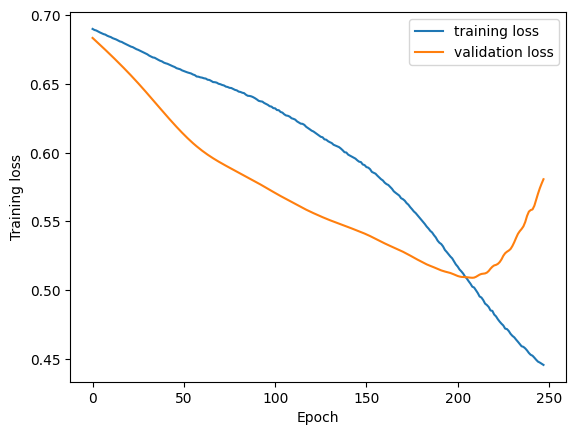

In [17]:
plt.plot(train_loss_hist, label='training loss')
plt.plot(val_loss_hist, label='validation loss')
plt.xlabel('Epoch')
plt.ylabel("Training loss")

# save training curve to folder
plt.savefig(os.path.join(save_dir, "training-hist.png"))
plt.legend()

## Run inference

In [18]:
 targets, preds = run_inference(model, test_graph_data, device=device, directed_graph=directed_graph)

In [19]:
report, cm = compute_metrics(targets, preds)

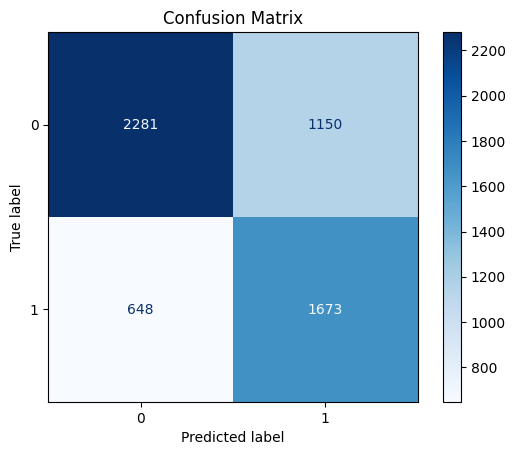

In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
# save confusion matrix to folder
plt.savefig(os.path.join(save_dir, "conf-mat.png"))
plt.show()

In [21]:
print(f"Classification report:\n", report)

Classification report:
               precision    recall  f1-score   support

     No-link       0.78      0.66      0.72      3431
  Link-exist       0.59      0.72      0.65      2321

    accuracy                           0.69      5752
   macro avg       0.69      0.69      0.68      5752
weighted avg       0.70      0.69      0.69      5752

